# GoogleNet 实现花卉识别
该项目可以帮助实现垃圾分类，类别包括："Aster", "Daisy", "Iris", "Lavender", "Lily", "Marigold", "Orchid", "Poppy", "Rose", "Sunflower"。

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


## 数据集下载及创建

In [3]:
!git lfs install
!git clone https://modelers.cn/xsir/flowerds.git

Git LFS initialized.
正克隆到 'flowerds'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [6]:
!unzip -q ./flowerds/dataset.zip -d ./flowerds/dataset

In [3]:
import os

import mindspore as ms
from mindspore.dataset import ImageFolderDataset
import mindspore.dataset.vision as transforms


data_path = './flowerds/dataset/'
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

dataset_train = ImageFolderDataset(os.path.join(data_path, "train"), shuffle=True)

trans_train = [
    transforms.RandomCropDecodeResize(size=224,
                                      scale=(0.08, 1.0),
                                      ratio=(0.75, 1.333)),
    transforms.RandomHorizontalFlip(prob=0.5),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_train = dataset_train.map(operations=trans_train, input_columns=["image"])
dataset_train = dataset_train.batch(batch_size=16, drop_remainder=True)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### GoogleNet网络结构


In [4]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal
from mindspore.ops import operations as P


def weight_variable():
    """Weight variable."""
    return TruncatedNormal(0.02)


class Conv2dBlock(nn.Cell):
    """
     Basic convolutional block
     Args:
         in_channles (int): Input channel.
         out_channels (int): Output channel.
         kernel_size (int): Input kernel size. Default: 1
         stride (int): Stride size for the first convolutional layer. Default: 1.
         padding (int): Implicit paddings on both sides of the input. Default: 0.
         pad_mode (str): Padding mode. Optional values are "same", "valid", "pad". Default: "same".
      Returns:
          Tensor, output tensor.
    """

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, pad_mode="same"):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=padding, pad_mode=pad_mode, weight_init=weight_variable())
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Inception(nn.Cell):
    """
    Inception Block
    """

    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.b1 = Conv2dBlock(in_channels, n1x1, kernel_size=1)
        self.b2 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red, kernel_size=1),
                                     Conv2dBlock(n3x3red, n3x3, kernel_size=3, padding=0)])
        self.b3 = nn.SequentialCell([Conv2dBlock(in_channels, n5x5red, kernel_size=1),
                                     Conv2dBlock(n5x5red, n5x5, kernel_size=3, padding=0)])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, pad_mode="same")
        self.b4 = Conv2dBlock(in_channels, pool_planes, kernel_size=1)
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        branch1 = self.b1(x)
        branch2 = self.b2(x)
        branch3 = self.b3(x)
        cell = self.maxpool(x)
        branch4 = self.b4(cell)
        return self.concat((branch1, branch2, branch3, branch4))


class GoogleNet(nn.Cell):
    """
    Googlenet architecture
    """

    def __init__(self, num_classes, include_top=True):
        super(GoogleNet, self).__init__()
        self.conv1 = Conv2dBlock(3, 64, kernel_size=7, stride=2, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.conv2 = Conv2dBlock(64, 64, kernel_size=1)
        self.conv3 = Conv2dBlock(64, 192, kernel_size=3, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.block3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.block3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.block4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.block4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.block4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.block4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.block4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode="same")

        self.block5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.block5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.dropout = nn.Dropout(p=0.2)
        self.include_top = include_top
        if self.include_top:
            self.mean = P.ReduceMean(keep_dims=True)
            self.flatten = nn.Flatten()
            self.classifier = nn.Dense(1024, num_classes, weight_init=weight_variable(),
                                       bias_init=weight_variable())


    def construct(self, x):
        """construct"""
        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.block3a(x)
        x = self.block3b(x)
        x = self.maxpool3(x)

        x = self.block4a(x)
        x = self.block4b(x)
        x = self.block4c(x)
        x = self.block4d(x)
        x = self.block4e(x)
        x = self.maxpool4(x)

        x = self.block5a(x)
        x = self.block5b(x)
        if not self.include_top:
            return x

        x = self.mean(x, (2, 3))
        x = self.flatten(x)
        x = self.classifier(x)

        return x


## 模型训练与推理

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等。

完整训练该模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [5]:
# 定义网络
network = GoogleNet(num_classes=10)

In [6]:
%%time
from mindspore.nn import LossBase
from mindspore.train import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore import train
from mindspore import ops
# define super parameter
epoch_size = 20
momentum = 0.9
resize = 224
step_size = dataset_train.get_dataset_size()
num_classes =10

# define learning rate
lr = nn.cosine_decay_lr(min_lr=float(0),
                        max_lr=0.00005,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=10)

# define optimizer
network_opt = nn.Adam(network.trainable_params(), lr, momentum)


# define loss function
class CrossEntropySmooth(LossBase):
    """CrossEntropy."""

    def __init__(self, sparse=True, reduction='mean', smooth_factor=0., num_classes=1000):
        super(CrossEntropySmooth, self).__init__()
        self.onehot = ops.OneHot()
        self.sparse = sparse
        self.on_value = ms.Tensor(1.0 - smooth_factor, ms.float32)
        self.off_value = ms.Tensor(1.0 * smooth_factor / (num_classes - 1), ms.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits(reduction=reduction)

    def construct(self, logit, label):
        if self.sparse:
            label = self.onehot(label, ops.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, label)
        return loss


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# set checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=5)
ckpt_callback = ModelCheckpoint(prefix='incetion_v2', directory='./inceptionv2', config=ckpt_config)

# initialize model
# "Ascend + mixed precision" can improve performance
ascend_target = (ms.get_context("device_target") == "Ascend")
if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O0")

# train model
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(125), TimeMonitor(125)],
            dataset_sink_mode=False,)

....epoch: 1 step: 125, loss is 1.8302896
epoch: 1 step: 250, loss is 1.9652021
epoch: 1 step: 375, loss is 1.7447984
epoch: 1 step: 500, loss is 1.786227
epoch: 1 step: 625, loss is 1.373209
epoch: 1 step: 750, loss is 1.5780174
epoch: 1 step: 875, loss is 1.7172956
Train epoch time: 245789.377 ms, per step time: 262.315 ms
epoch: 2 step: 63, loss is 1.5107399
epoch: 2 step: 188, loss is 1.9155626
epoch: 2 step: 313, loss is 1.506851
epoch: 2 step: 438, loss is 1.6557792
epoch: 2 step: 563, loss is 1.2988815
epoch: 2 step: 688, loss is 1.6787984
epoch: 2 step: 813, loss is 1.5473788
Train epoch time: 190120.788 ms, per step time: 202.904 ms
epoch: 3 step: 1, loss is 1.6737626
epoch: 3 step: 126, loss is 1.4822857
epoch: 3 step: 251, loss is 1.2596834
epoch: 3 step: 376, loss is 1.1988889
epoch: 3 step: 501, loss is 1.8051696
epoch: 3 step: 626, loss is 1.5634254
epoch: 3 step: 751, loss is 1.3403487
epoch: 3 step: 876, loss is 1.5850503
Train epoch time: 190176.077 ms, per step time: 

### 模型验证

模型验证过程主要应用了ImageFolderDataset，CrossEntropySmooth和Model等接口。

ImageFolderDataset主要用于读取数据集。

CrossEntropySmooth是损失函数实例化接口。

Model主要用于编译模型。

与训练过程相似，首先进行数据增强，然后定义GoogleNet网络结构，加载预训练模型参数。随后设置损失函数，评价指标等，编译模型后进行验证。本案例采用了业界通用的评价标准Top_1_Accuracy评价指标来评价模型表现。

In [7]:
dataset_val = ImageFolderDataset(os.path.join(data_path, "val"), shuffle=True)

trans_val = [
    transforms.Decode(),
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_val = dataset_val.map(operations=trans_val, input_columns=["image"])
dataset_val = dataset_val.batch(batch_size=16, drop_remainder=True)


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# define metric
eval_metrics = {'Top_1_Accuracy': train.Top1CategoricalAccuracy()}

if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O0")

# evaluate model
result = model.eval(dataset_val)
print(result)

.{'Top_1_Accuracy': 0.8018830128205128}


从结果可以看出，由于我们加载了预训练模型参数，模型的Top_1_Accuracy和Top_5_Accuracy达到了很高的水平，实际项目中也可以以此准确率为标准。如果未使用预训练模型参数，则需要更多的epoch来训练。

### 模型推理


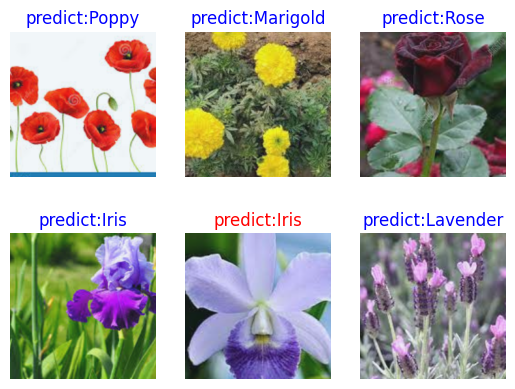

In [8]:
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
output = network(data['image'])
pred = np.argmax(output.asnumpy(), axis=1)

# 图像分类
classes = ["Aster", "Daisy", "Iris", "Lavender", "Lily", "Marigold",
           "Orchid", "Poppy", "Rose", "Sunflower"]

# 显示图像及图像的预测值
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
    plt.title('predict:{}'.format(classes[pred[i]]), color=color)
    picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    picture_show = std * picture_show + mean
    picture_show = np.clip(picture_show, 0, 1)
    plt.imshow(picture_show)
    plt.axis('off')

plt.show()